## Data challenge - Predicting conversion using user logs

[Executive summary](#tag1)

[Preprocessing](#tag2)

[Feature engineering](#tag3)

[Model comparison](#tag4)

[Limitation and discussion](#tag5)

<a id='tag1'></a>
### Executive summary

The purpose of this model is to predict the outcome of advertising compaign (Conversion or no conversion). The input features includes a variety of information from user logs, such as the time of the click, the device type, the advertisement content, etc. The target is whether or not the conversion occured. We want to capture users who are most likely to convert. Using ***random forest and ensemble models***, we are able to achieve ***0.83 AUC (area under the curve)***. To build these two models, we have selected the scaler for numeric features, selected the best features from both numerical features and categorical features using ***selectKbest***, perfomed ***grirSearchCV*** to find the best hyperparameters, and selected models based on ***AUC***. To improve the model performance, more advanced techniques for feature extraction and feature engineering need to be implemented.

<a id='tag2'></a>
### Preprocessing

This includes the following steps:

   * Subset data to the correct date
   * Scale the numeric feature
   * One-hot encode the categorical feature 
       * Categorical features with more than 200 categories were excluded from the training set
   * Using **RandomUndersampler** to get two balanced dataset
   
Below is a part of the code used for data prepossing.

In [2]:
from sklearn.preprocessing import MaxAbsScaler
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn import pipeline
from sklearn.feature_selection import chi2, mutual_info_regression, f_regression, mutual_info_classif, f_classif, SelectFdr
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import mglearn
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
%matplotlib inline

In [27]:
train_data = pd.read_table('train_data.txt', delimiter='\t')
test_data = pd.read_table('test_data.txt', delimiter='\t')

train_date = [int(str(i)[:8]) for i in train_data['time']]
test_date = [int(str(i)[:8]) for i in test_data['time']]

## get the correct date from the training and testing data
subset_train = [ i == 20170808 for i in train_date]
subset_test = [ i == 20170809 for i in test_date]

train_data_correct = train_data.loc[subset_train]
test_data_correct = test_data.loc[subset_test]

x_train = train_data_correct.drop(['sample_id', 'label', 'week'], axis=1)
y_train = train_data_correct['label']

x_test = test_data_correct.drop(['sample_id', 'label', 'week'], axis=1)
y_test = test_data_correct['label']

label_encode = LabelEncoder()
stadard_scaler = StandardScaler()
onehot_encode = OneHotEncoder()

In [4]:
data_all = pd.concat([x_train, x_test], axis=0, ignore_index = True)

## select categorical data with only less than 200 categories
data_obj = data_all.select_dtypes(include=['object'])\
.copy().iloc[:, [ 0,  1,  3,  6,  8,  9, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22]]

Here we exclude columns with more than 200 categories (pd.Series.nunqiue < 200) for two reasons:

1. One-hot encoding on these columns will produce a large sparse matrix and slow down the computation time 
2. We build a simple model using only columns with more than 200 categories, which confers only 0.6 AUC

In [5]:
data_num = data_all.select_dtypes(include=['int64']).copy()


We have tried **StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler**, the final model uses **MaxAbsScaler** 

In [6]:
max_scale = MaxAbsScaler()
data_num_scaled = max_scale.fit_transform(np.array(data_num).astype(float))
data_num_pd = pd.DataFrame(data_num_scaled, columns=data_num.columns)
final = pd.concat([data_num_pd, data_obj], axis = 1, ignore_index=True)

## one hot encoding for categorical 
final_dummy = pd.get_dummies(final)

## split data back to training and testing data
x_train_final = final_dummy.iloc[:(4500638),:]
x_test_final = final_dummy.iloc[(4500638):,:]

The scatterplot below is a PCA representation of all numerical features in the training set (after MaxAbsScaler()).

In [7]:
pca = PCA(n_components=2)
x_train_final_num_columns_pca = pca.fit_transform(x_train_final.select_dtypes(include=['float64']).copy())


In [8]:
a1 = np.array(x_train_final_num_columns_pca[:,0])
a2 = np.array(x_train_final_num_columns_pca[:,1])

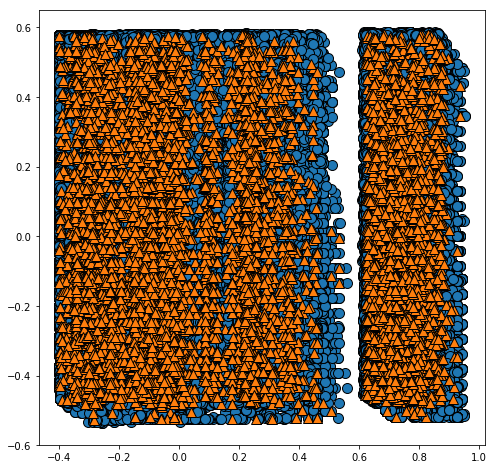

In [9]:
import mglearn
plt.figure(figsize = (8,8))
mglearn.discrete_scatter(a1, a2, y_train)

The histogram below compares the frequency of categorical features (categorical features are encoded using label encoder). The columns whose distribution are different between different conversion groups include: ad_type, country_code, os_version, etc.

In [17]:
x_train_obj = x_train.select_dtypes(include=['object']).copy()

In [18]:
label_encode = LabelEncoder()

In [19]:
x_train_obj_encode = x_train_obj.apply(label_encode.fit_transform)

In [20]:
plot_frame = pd.concat([x_train_obj_encode.reset_index(drop = True), \
                        y_train.reset_index(drop=True)], axis = 1)


label
0    [[Axes(0.125,0.725918;0.0610236x0.154082), Axe...
1    [[Axes(0.125,0.725918;0.0610236x0.154082), Axe...
dtype: object

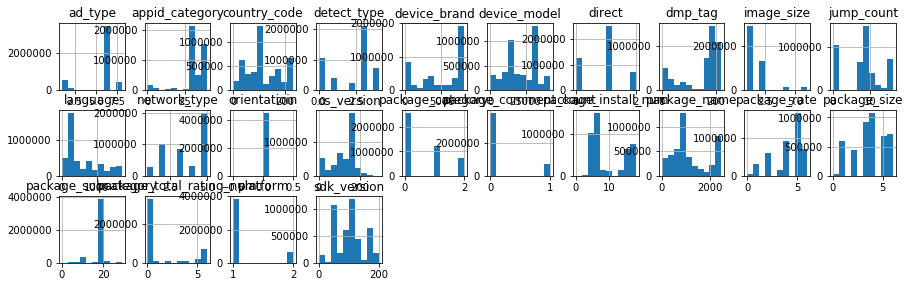

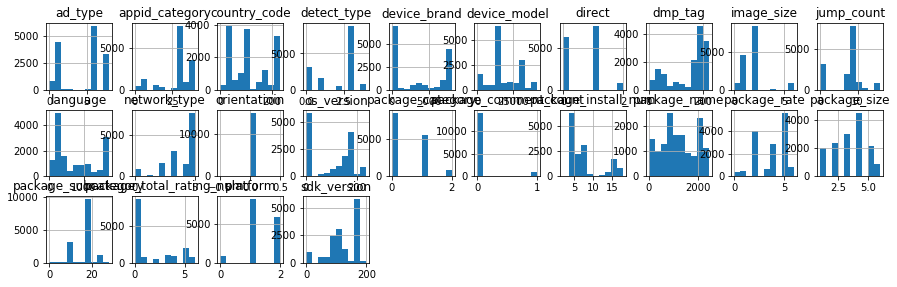

In [30]:
plt.rcParams["figure.figsize"] = (15,6)
plot_frame.groupby('label').hist(layout = (4, 10))

In [31]:
pd.Series(y_train).value_counts() ## imbalanced target 

0    4485799
1      14839
Name: label, dtype: int64

Because the original dataset is very imbalanced (There are way more users that are in the non-conversion group), the original dataset is not very good for building classification models. We have captured more variation in the non-conversion group and less variation in the conversion group. One way to train a less biased classifier is to use RandomUndersampler from **imblearn** module.

Below is the code for undersampling.

In [ ]:
US = RandomUnderSampler(return_indices=True)
x_train_final_US, y_train_US, idx_US = US.fit_sample(x_train_final, y_train)

<a id='tag3'></a>
### Feature engineering

This includes using ***GridSearchCV*** to findthe best K of features.
Below is a part of the code. 

We selected the number of K separately by building simple models. The final model includes ***5 numerical features and 65 categorical features***.

In [14]:
## Undersampled numberical feature + select K best + random forest
x_train_final = pickle.load( open( "x_train_num_maxAbs.pickle", "rb" ) )
x_test_final = pickle.load(open("x_test_num_maxAbs.pickle", "rb"))
y_train = pickle.load(open("y_train.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))
idx_US = pickle.load(open('under_sampling_idx.pickle', "rb"))

In [17]:
x_train_final_US = x_train_final.iloc[idx_US,:]
y_train_US = y_train.iloc[idx_US]

In [18]:
N_FEATURES_OPTIONS = [3, 5, 7]
param_grid = [
    {
        'selectK__k': N_FEATURES_OPTIONS,
    },
]

In [19]:
model1 = Pipeline([ 
    ('selectK',  SelectKBest(score_func=mutual_info_classif)),  
    ('rf', RandomForestClassifier())
])
grid = GridSearchCV(model1, param_grid=param_grid, cv=2, n_jobs=1)

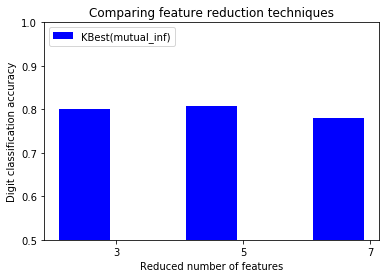

In [21]:
grid.fit(x_train_final_US, y_train_US)
reducer_labels = [ 'KBest(mutual_inf)']
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(1, -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0.5, 1))
plt.legend(loc='upper left')
plt.show()

The above barplot shows 5 features perform the best.

<a id='tag4'></a>
### Model comparison

We have tried several classfication models and selected Random forest as the best by comparing AUC.

Below is a table of model performance.

In [22]:
compare = pd.read_table('model-compare.txt', delimiter='\t')

In [31]:
pd.set_option('display.width', pd.util.terminal.get_terminal_size()[0])
compare.style.set_properties(**{'width': '300px'})

Below is the code to build the final model.

In [4]:
x_train_obj = pickle.load(open('x_train_obj.pickle', 'rb'))

In [5]:
x_train_num = pickle.load(open('x_train_num_maxAbs.pickle', 'rb'))

In [6]:
x_test_obj = pickle.load(open('x_test_obj.pickle', 'rb'))

In [7]:
x_test_num = pickle.load(open('x_test_num_maxAbs.pickle', 'rb'))

In [8]:
y_train = pickle.load(open('y_train.pickle', 'rb'))
y_test = pickle.load(open('y_test.pickle', 'rb'))

In [9]:
US_idx = pickle.load(open('under_sampling_idx.pickle', 'rb'))

In [10]:
x_train_obj_US = x_train_obj.iloc[US_idx, :]
x_train_num_US = x_train_num.iloc[US_idx, :]

y_train_US = y_train.iloc[US_idx]

In [11]:
selector1 = SelectKBest(score_func=mutual_info_classif, k = 5)
selector2 = SelectKBest(score_func=mutual_info_classif, k = 65)

In [12]:
x_train_obj_select = selector2.fit_transform(x_train_obj_US, y_train_US)

In [13]:
x_train_num_select = selector1.fit_transform(x_train_num_US, y_train_US)

In [14]:
x_feature_all = pd.concat([pd.DataFrame(x_train_obj_select).reset_index(drop=True),\
                           pd.DataFrame(x_train_num_select).reset_index(drop=True)], \
                         axis = 1)

In [15]:
selected_1 = np.where(selector1.get_support() == True)[0]

In [16]:
selected_2 = np.where(selector2.get_support() == True)[0]

In [17]:
x_test_obj_select = x_test_obj.iloc[:, selected_2]

In [18]:
x_test_num_select = x_test_num.iloc[:, selected_1]

In [19]:
test_feature_all = pd.concat([pd.DataFrame(x_test_obj_select).reset_index(drop=True),\
                           pd.DataFrame(x_test_num_select).reset_index(drop=True)], \
                         axis = 1)

In [20]:
model1 = Pipeline([ 
    ('rf', RandomForestClassifier(criterion='entropy', max_depth=None, max_features=20))
])

In [21]:
model1.fit(x_feature_all, y_train_US)

Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

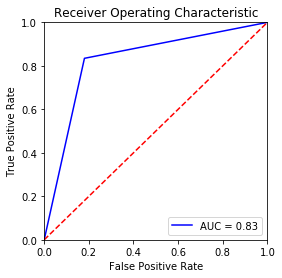

In [22]:
y_test_pred = model1.predict(test_feature_all)
plt.rcParams["figure.figsize"] = (4,4)

fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a id='tag5'></a>
### Limitation and discussion

There are three things that I haven't try to improve the model performance, includes:

* The prompt of this data challenge indicates that ***there are both conversion and non-conversion label in some sample_id***. I interpret it as ***The same user sometimes convert and sometimes does not convert***. To include the stochasticity of such results, I choose to retain the original data as it is. There are two other ways to deal with it:

    1. *** Instead of a deterministic model, build a stochastic model to predict the conversion***
    2. *** Put more weight on convert group that do not have a same sample id in the non-conversion group***. This was not implemented in our model. There might be disadvantages of such weighting: emphasize more on the condition that confers conversion but less focus on the condition that confers binary results.


* More sophisticated way of treating the variable types: for example, MCC_MNC indicate the mobile country code and mobile area code, in this case it is treated as a numerical variable. Since the value of these code does not porvides real meaning to the target, it is more reasonable to create categorical variable for these features. If there are too many categories, we can still reduce the categories by putting categories into two or three 'buckets'.


* There are serveral categorical columns are excluded from this analysis, since adding those does not produce better performance. There maybe better way to extract features from those excluded columns.

* To cluster the features as numeric and category may be not the best solution. A better way to cluster the features are based on the ***correlation between features and target***. We can choose to model the features that have the highest association with the predicted target.